In [132]:
# Import libraries that will be needed for the lab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import os, datetime
import seaborn as sns

import sklearn
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import DecisionBoundaryDisplay


import tensorflow as tf
from tensorflow.keras import optimizers, layers, losses, regularizers 
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
%load_ext tensorboard
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [134]:
sklearn.__version__

'1.3.0'

In [135]:
# Download the dataset
dataset = pd.read_csv('testw.csv')
raw_data = dataset.values
dataset=dataset.drop('Index', axis=1)
dataset.head()

,Time,Identifier,Src_IP,Src_MAC,Dest_IP,Dest_MAC,Src_Port,Dest_Port,Proto,Seq_Num,Ack_Num,TCP_Flag,Window_Size,TCP_Checksum,Packet_Length,Payload
0,1.518611e+09,6058,0,0,0,0,49459.0,80.0,6.0,4.148861e+09,1.694791e+09,PA,256.0,24061.0,375.0,1.732513
1,1.518611e+09,46552,1,1,1,1,80.0,49459.0,6.0,1.694791e+09,4.148861e+09,A,980.0,56192.0,1500.0,1.726963
2,1.518611e+09,46553,1,1,1,1,80.0,49459.0,6.0,1.694793e+09,4.148861e+09,PA,980.0,13256.0,262.0,1.732513
3,1.518611e+09,6059,0,0,0,0,49459.0,80.0,6.0,4.148861e+09,1.694793e+09,A,256.0,23726.0,40.0,1.542778
4,1.518611e+09,12238,0,0,2,0,137.0,137.0,17.0,4.148861e+09,1.694793e+09,A,256.0,23726.0,78.0,1.153846


In [136]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22603 entries, 0 to 22602
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Time           22603 non-null  float64
 1   Identifier     22603 non-null  int64  
 2   Src_IP         22603 non-null  int64  
 3   Src_MAC        22603 non-null  int64  
 4   Dest_IP        22603 non-null  int64  
 5   Dest_MAC       22603 non-null  int64  
 6   Src_Port       22322 non-null  float64
 7   Dest_Port      22322 non-null  float64
 8   Proto          22225 non-null  float64
 9   Seq_Num        22241 non-null  float64
 10  Ack_Num        22241 non-null  float64
 11  TCP_Flag       22241 non-null  object 
 12  Window_Size    22241 non-null  float64
 13  TCP_Checksum   22241 non-null  float64
 14  Packet_Length  22219 non-null  float64
 15  Payload        22603 non-null  float64
dtypes: float64(10), int64(5), object(1)
memory usage: 2.8+ MB


In [137]:

freq_imputer = SimpleImputer(strategy='most_frequent')

protocol = dataset.drop('Proto', axis=1)


dataset.Proto = freq_imputer.fit_transform(protocol)

# Calculate the mode value of column 'B'
mode_value = dataset['TCP_Flag'].mode()[0]

# Fill missing values in column 'B' with the mode value
dataset['TCP_Flag'] = dataset['TCP_Flag'].fillna(mode_value)
#Drop a row where the source port and destination ports are not known

dataset = dataset.dropna(subset=["Dest_Port"])


In [138]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22322 entries, 0 to 22599
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Time           22322 non-null  float64
 1   Identifier     22322 non-null  int64  
 2   Src_IP         22322 non-null  int64  
 3   Src_MAC        22322 non-null  int64  
 4   Dest_IP        22322 non-null  int64  
 5   Dest_MAC       22322 non-null  int64  
 6   Src_Port       22322 non-null  float64
 7   Dest_Port      22322 non-null  float64
 8   Proto          22322 non-null  object 
 9   Seq_Num        22241 non-null  float64
 10  Ack_Num        22241 non-null  float64
 11  TCP_Flag       22322 non-null  object 
 12  Window_Size    22241 non-null  float64
 13  TCP_Checksum   22241 non-null  float64
 14  Packet_Length  22219 non-null  float64
 15  Payload        22322 non-null  float64
dtypes: float64(9), int64(5), object(2)
memory usage: 2.9+ MB


#### It is unusual to have zero as the value of sequence number and acknowledgment number

In [139]:
dataset.Ack_Num = dataset.Ack_Num.fillna(0)#zero_imputer.fit_transform(ack_num)
dataset.Seq_Num = dataset.Seq_Num.fillna(0)#zero_imputer.fit_transform(seq_num)

In [140]:
dataset.head()

,Time,Identifier,Src_IP,Src_MAC,Dest_IP,Dest_MAC,Src_Port,Dest_Port,Proto,Seq_Num,Ack_Num,TCP_Flag,Window_Size,TCP_Checksum,Packet_Length,Payload
0,1.518611e+09,6058,0,0,0,0,49459.0,80.0,1518611407.527612,4.148861e+09,1.694791e+09,PA,256.0,24061.0,375.0,1.732513
1,1.518611e+09,46552,1,1,1,1,80.0,49459.0,1518611407.560223,1.694791e+09,4.148861e+09,A,980.0,56192.0,1500.0,1.726963
2,1.518611e+09,46553,1,1,1,1,80.0,49459.0,1518611407.560264,1.694793e+09,4.148861e+09,PA,980.0,13256.0,262.0,1.732513
3,1.518611e+09,6059,0,0,0,0,49459.0,80.0,1518611407.560288,4.148861e+09,1.694793e+09,A,256.0,23726.0,40.0,1.542778
4,1.518611e+09,12238,0,0,2,0,137.0,137.0,1518611408.107436,4.148861e+09,1.694793e+09,A,256.0,23726.0,78.0,1.153846


#### For median imputer

In [141]:
dataset[['TCP_Checksum', 'Packet_Length', 'Window_Size']] = dataset[['TCP_Checksum', 'Packet_Length', 'Window_Size']].fillna(dataset[['TCP_Checksum', 'Packet_Length', 'Window_Size']].median())

In [142]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22322 entries, 0 to 22599
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Time           22322 non-null  float64
 1   Identifier     22322 non-null  int64  
 2   Src_IP         22322 non-null  int64  
 3   Src_MAC        22322 non-null  int64  
 4   Dest_IP        22322 non-null  int64  
 5   Dest_MAC       22322 non-null  int64  
 6   Src_Port       22322 non-null  float64
 7   Dest_Port      22322 non-null  float64
 8   Proto          22322 non-null  object 
 9   Seq_Num        22322 non-null  float64
 10  Ack_Num        22322 non-null  float64
 11  TCP_Flag       22322 non-null  object 
 12  Window_Size    22322 non-null  float64
 13  TCP_Checksum   22322 non-null  float64
 14  Packet_Length  22322 non-null  float64
 15  Payload        22322 non-null  float64
dtypes: float64(9), int64(5), object(2)
memory usage: 2.9+ MB


In [143]:
ord_encoder = OrdinalEncoder()
dataset['TCP_Flag'] = ord_encoder.fit_transform(dataset[['TCP_Flag']])

In [144]:
dataset.head()

,Time,Identifier,Src_IP,Src_MAC,Dest_IP,Dest_MAC,Src_Port,Dest_Port,Proto,Seq_Num,Ack_Num,TCP_Flag,Window_Size,TCP_Checksum,Packet_Length,Payload
0,1.518611e+09,6058,0,0,0,0,49459.0,80.0,1518611407.527612,4.148861e+09,1.694791e+09,2.0,256.0,24061.0,375.0,1.732513
1,1.518611e+09,46552,1,1,1,1,80.0,49459.0,1518611407.560223,1.694791e+09,4.148861e+09,0.0,980.0,56192.0,1500.0,1.726963
2,1.518611e+09,46553,1,1,1,1,80.0,49459.0,1518611407.560264,1.694793e+09,4.148861e+09,2.0,980.0,13256.0,262.0,1.732513
3,1.518611e+09,6059,0,0,0,0,49459.0,80.0,1518611407.560288,4.148861e+09,1.694793e+09,0.0,256.0,23726.0,40.0,1.542778
4,1.518611e+09,12238,0,0,2,0,137.0,137.0,1518611408.107436,4.148861e+09,1.694793e+09,0.0,256.0,23726.0,78.0,1.153846


In [145]:
lab = raw_data[:, -1]

lab.shape

(22603,)

In [146]:
train_data, test_data = train_test_split(
    dataset, test_size=0.2, random_state=42
)

In [147]:
test_data.shape

(4465, 16)

In [148]:
max(dataset.Ack_Num)

4292548908.0

#### Normalize the data to [0,1]

In [150]:
train_data_nparray = np.asarray(train_data).astype(np.float32)
test_data_nparray = np.asarray(test_data).astype(np.float32)

min_val = np.min(train_data_nparray) # tf.reduce_min(train_data)
max_val = np.max(test_data_nparray) #tf.reduce_max(train_data)

train_data_norm = (train_data_nparray - min_val) / (max_val - min_val)
test_data_norm = (test_data_nparray - min_val) / (max_val - min_val)

In [151]:
train_data_norm

array([[3.53778809e-01, 6.24500763e-06, 6.75589273e-09, ...,
        8.76658669e-06, 3.49442729e-07, 4.09800971e-10],
       [3.53778809e-01, 5.05690241e-06, 6.75589273e-09, ...,
        5.08998301e-06, 3.49442729e-07, 4.09800971e-10],
       [3.53778809e-01, 5.69521762e-06, 6.75589273e-09, ...,
        8.89564672e-06, 3.49442729e-07, 4.09800971e-10],
       ...,
       [3.53778809e-01, 3.65051164e-06, 0.00000000e+00, ...,
        1.51422855e-05, 9.31847310e-09, 3.69257097e-10],
       [3.53778511e-01, 3.46018192e-06, 0.00000000e+00, ...,
        1.51422855e-05, 9.31847310e-09, 3.82385040e-10],
       [3.53778809e-01, 4.48335004e-06, 0.00000000e+00, ...,
        1.51422855e-05, 9.31847310e-09, 3.69257097e-10]], dtype=float32)

In [152]:
np.max(train_data_norm)

1.0

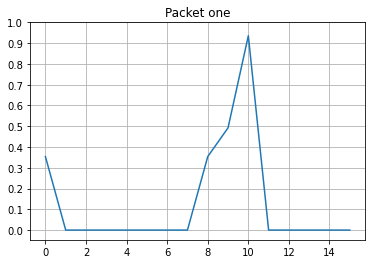

In [153]:
plt.grid()
plt.plot(np.arange(16), train_data_norm[1])
plt.title("Packet one")
plt.yticks([i/10 for i in range(11)])
plt.show()

In [154]:
class SparseAnomalyDetector(Model):
    def __init__(self):
        super(SparseAnomalyDetector, self).__init__()
        self.encoder = layers.Dense(16, activation="relu", activity_regularizer=regularizers.l1(10e-5))

        self.decoder = layers.Dense(16, activation="sigmoid")
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = SparseAnomalyDetector()

In [155]:
#autoencoder.layers[0].bias.numpy()

In [156]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#Strop training when overfitting is detected
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                  patience=5, 
                                                  min_delta=0.001, 
                                                  mode='auto', 
                                                  verbose=2, 
                                                  baseline=None, 
                                                  restore_best_weights=True)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,profile_batch=0,update_freq='epoch',histogram_freq=1)


In [157]:
history = autoencoder.fit(train_data_norm, train_data_norm,
          epochs=100, 
          batch_size=256,
          validation_data=(test_data_norm, test_data_norm),
          shuffle=True,
          callbacks=[early_stopping, tensorboard_callback])

Epoch 1/100
70/70 [==============================] - 1s 3ms/step - loss: 0.6292 - accuracy: 0.5965 - val_loss: 0.5600 - val_accuracy: 0.6121
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 0.4705 - accuracy: 0.6759 - val_loss: 0.3762 - val_accuracy: 0.7006
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 0.3052 - accuracy: 0.7094 - val_loss: 0.2486 - val_accuracy: 0.7050
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 0.2213 - accuracy: 0.7128 - val_loss: 0.2003 - val_accuracy: 0.7080
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 0.1898 - accuracy: 0.8833 - val_loss: 0.1809 - val_accuracy: 0.9109
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 0.1760 - accuracy: 0.9074 - val_loss: 0.1714 - val_accuracy: 0.9272
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 0.1683 - accuracy: 0.9302 - val_loss: 0.1652 - val_accuracy: 0.9324
Epoch 8/100
7

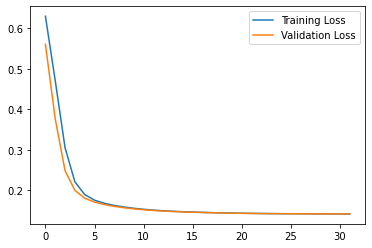

In [158]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.savefig('Training_Loss.png')

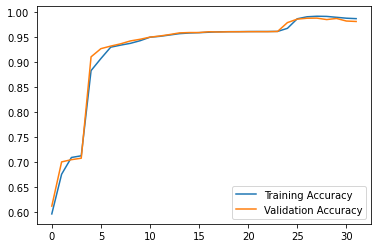

In [159]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.savefig("Training Accuracy.png")

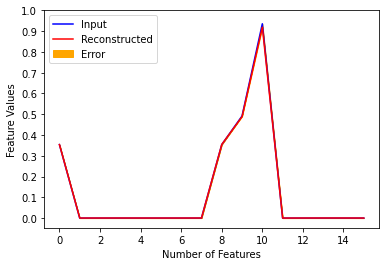

In [160]:
encoded_data = autoencoder.encoder(test_data_norm).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(test_data_norm[156], 'b')
plt.plot(decoded_data[156], 'r')
plt.fill_between(np.arange(16), decoded_data[131], test_data_norm[131], color='orange')
plt.legend(labels=["Input", "Reconstructed", "Error"])
plt.ylabel('Feature Values')
plt.xlabel('Number of Features')
plt.yticks([i/10 for i in range(11)])
plt.savefig("rec_0.png")
plt.show()

In [161]:
autoencoder.summary()

Model: "sparse_anomaly_detector_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             multiple                  272       
                                                                 
 dense_3 (Dense)             multiple                  272       
                                                                 
Total params: 544
Trainable params: 544
Non-trainable params: 0
_________________________________________________________________


In [162]:
#tf.saved_model.save(autoencoder, 'tensormodel/1')

In [163]:
#%tensorboard --logdir logs

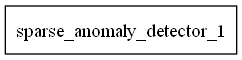

In [164]:
plot_model(
    autoencoder, 
    to_file='autoencoder_model1.png', 
    show_shapes=True, 
    show_layer_names=True, 
    rankdir='TB' # TB for top to bottom, LR for left to right
)

Image(filename='autoencoder_model1.png')

559/559 [==============================] - 0s 530us/step


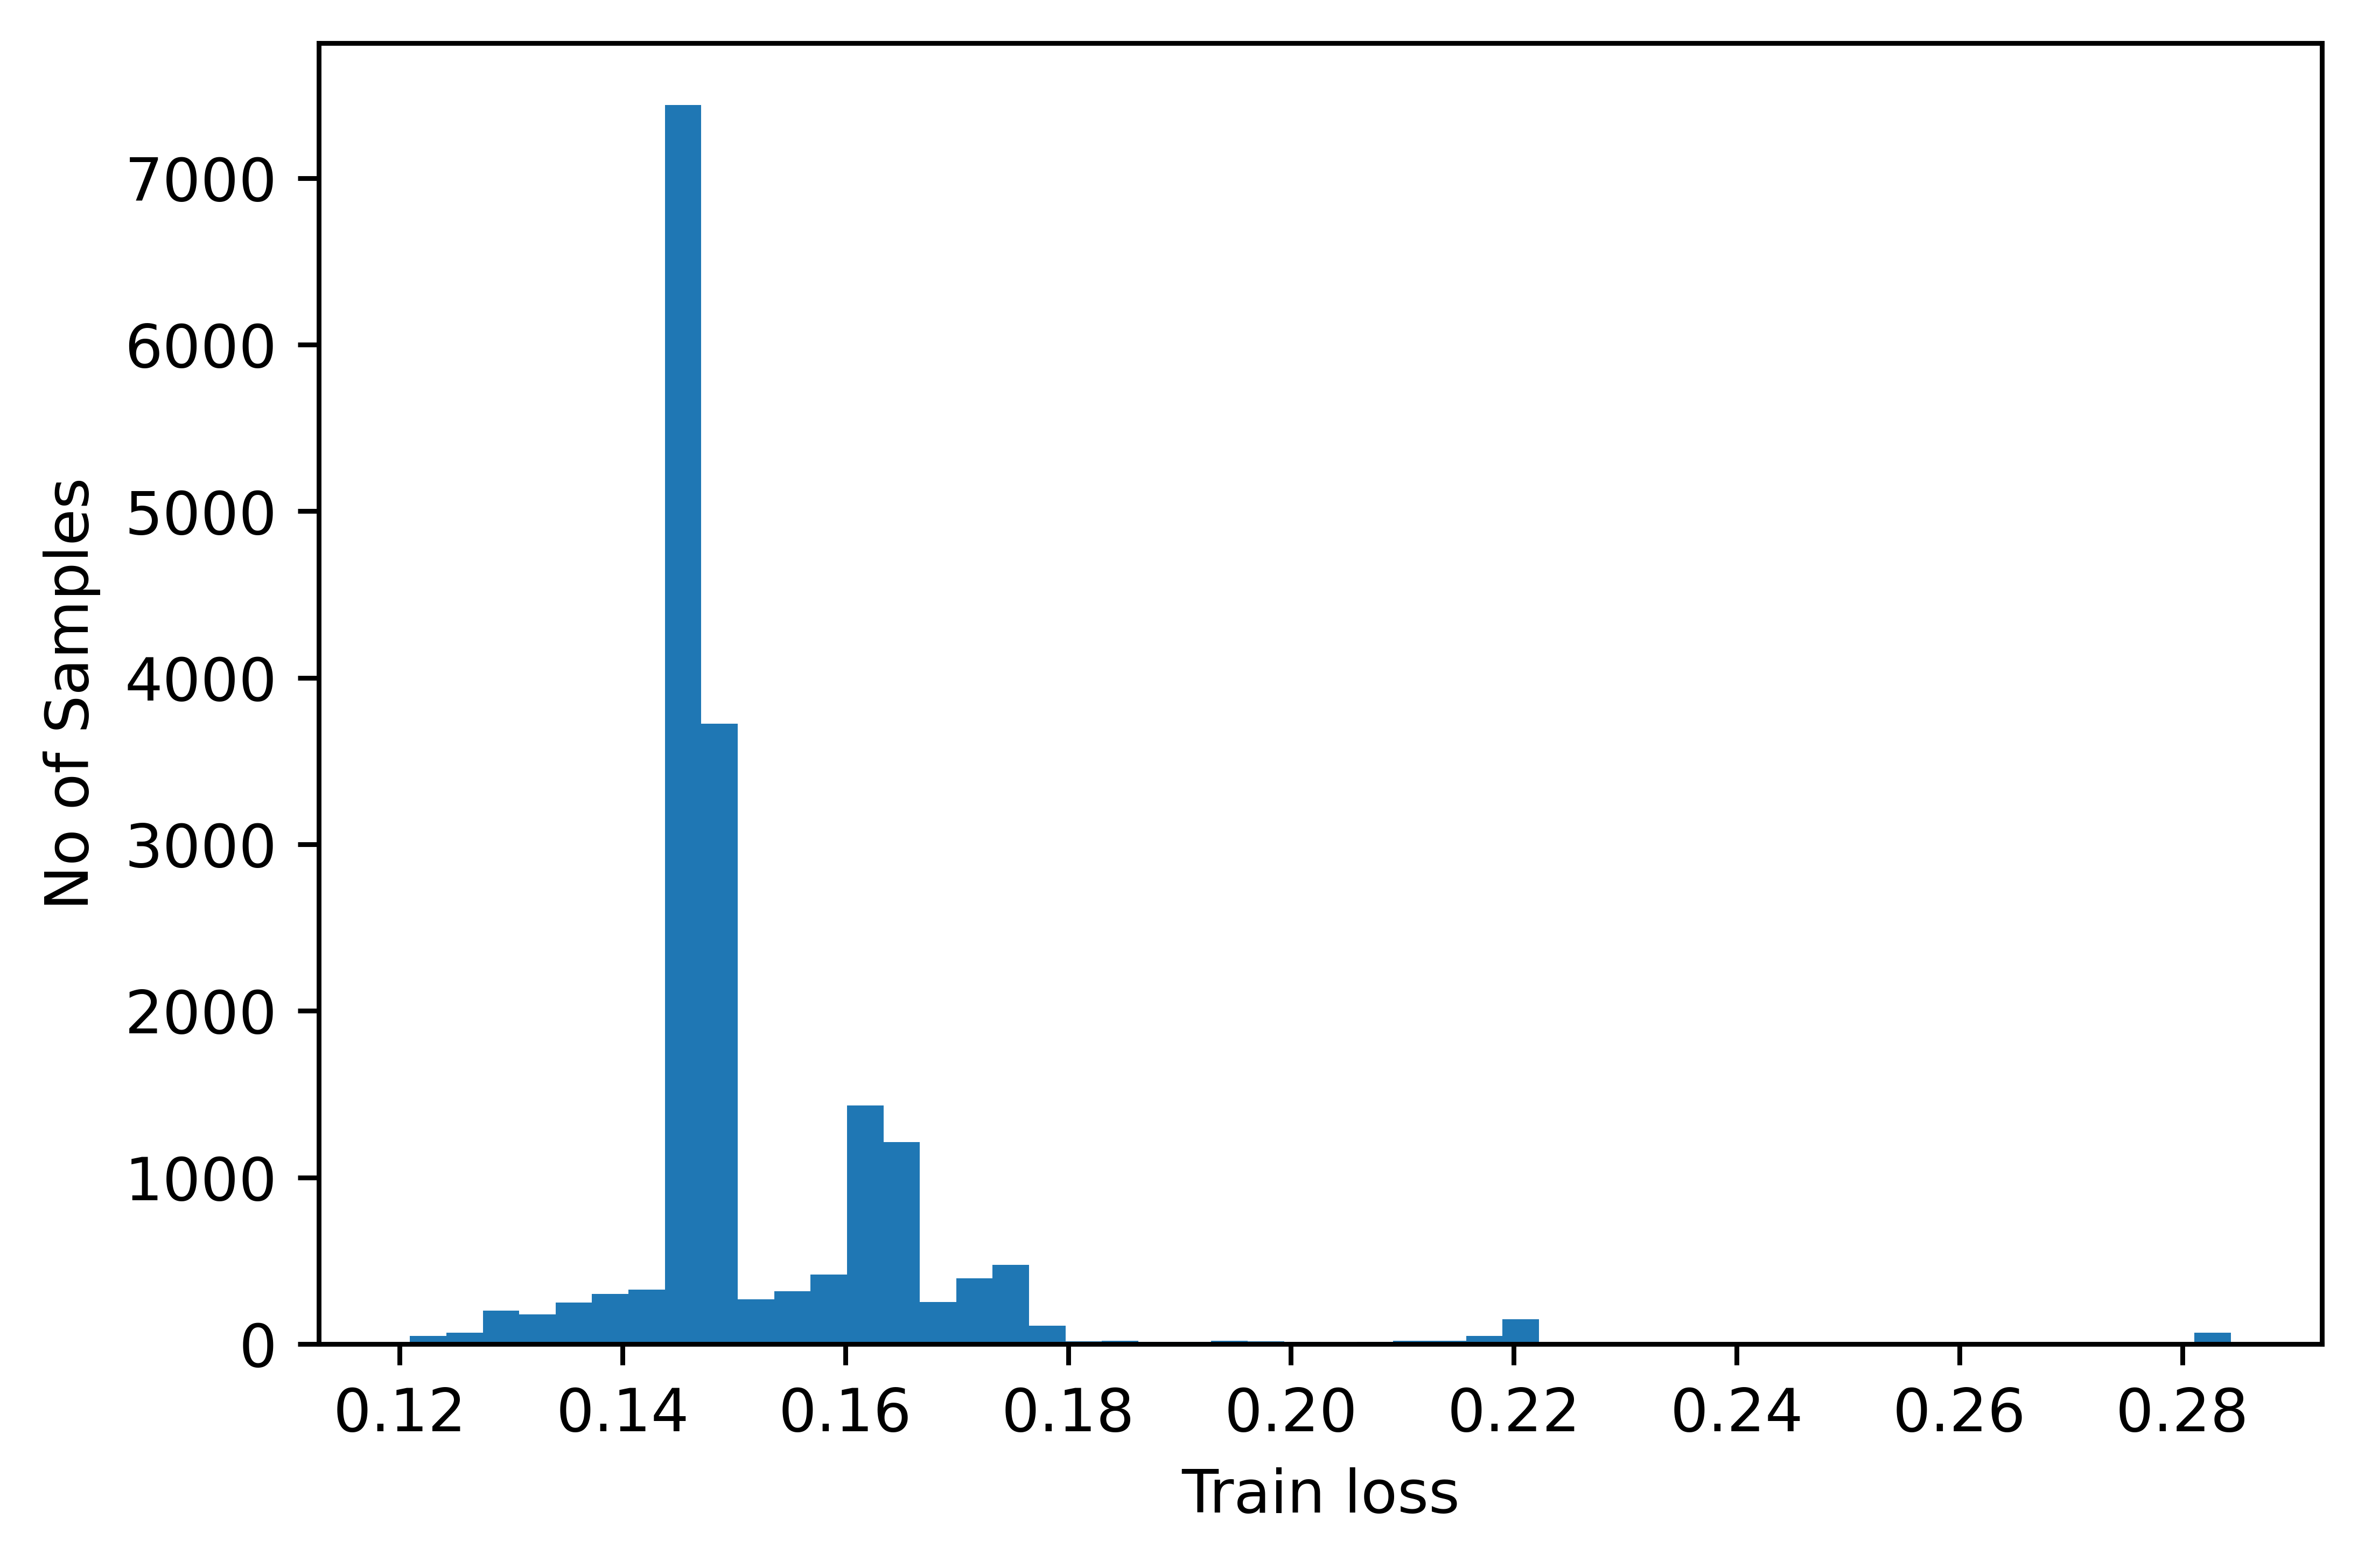

In [165]:
reconstructions = autoencoder.predict(train_data_norm)
train_loss = tf.keras.losses.binary_crossentropy(reconstructions, train_data_norm)

fig, axe = plt.subplots(dpi=800)

n, bins, _ = axe.hist(train_loss[None,:], bins=50)

plt.xlabel("Train loss")
plt.ylabel("No of Samples")
plt.savefig("Training Loss Distribution.png")
plt.show()

C:\Users\Kasutaja\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


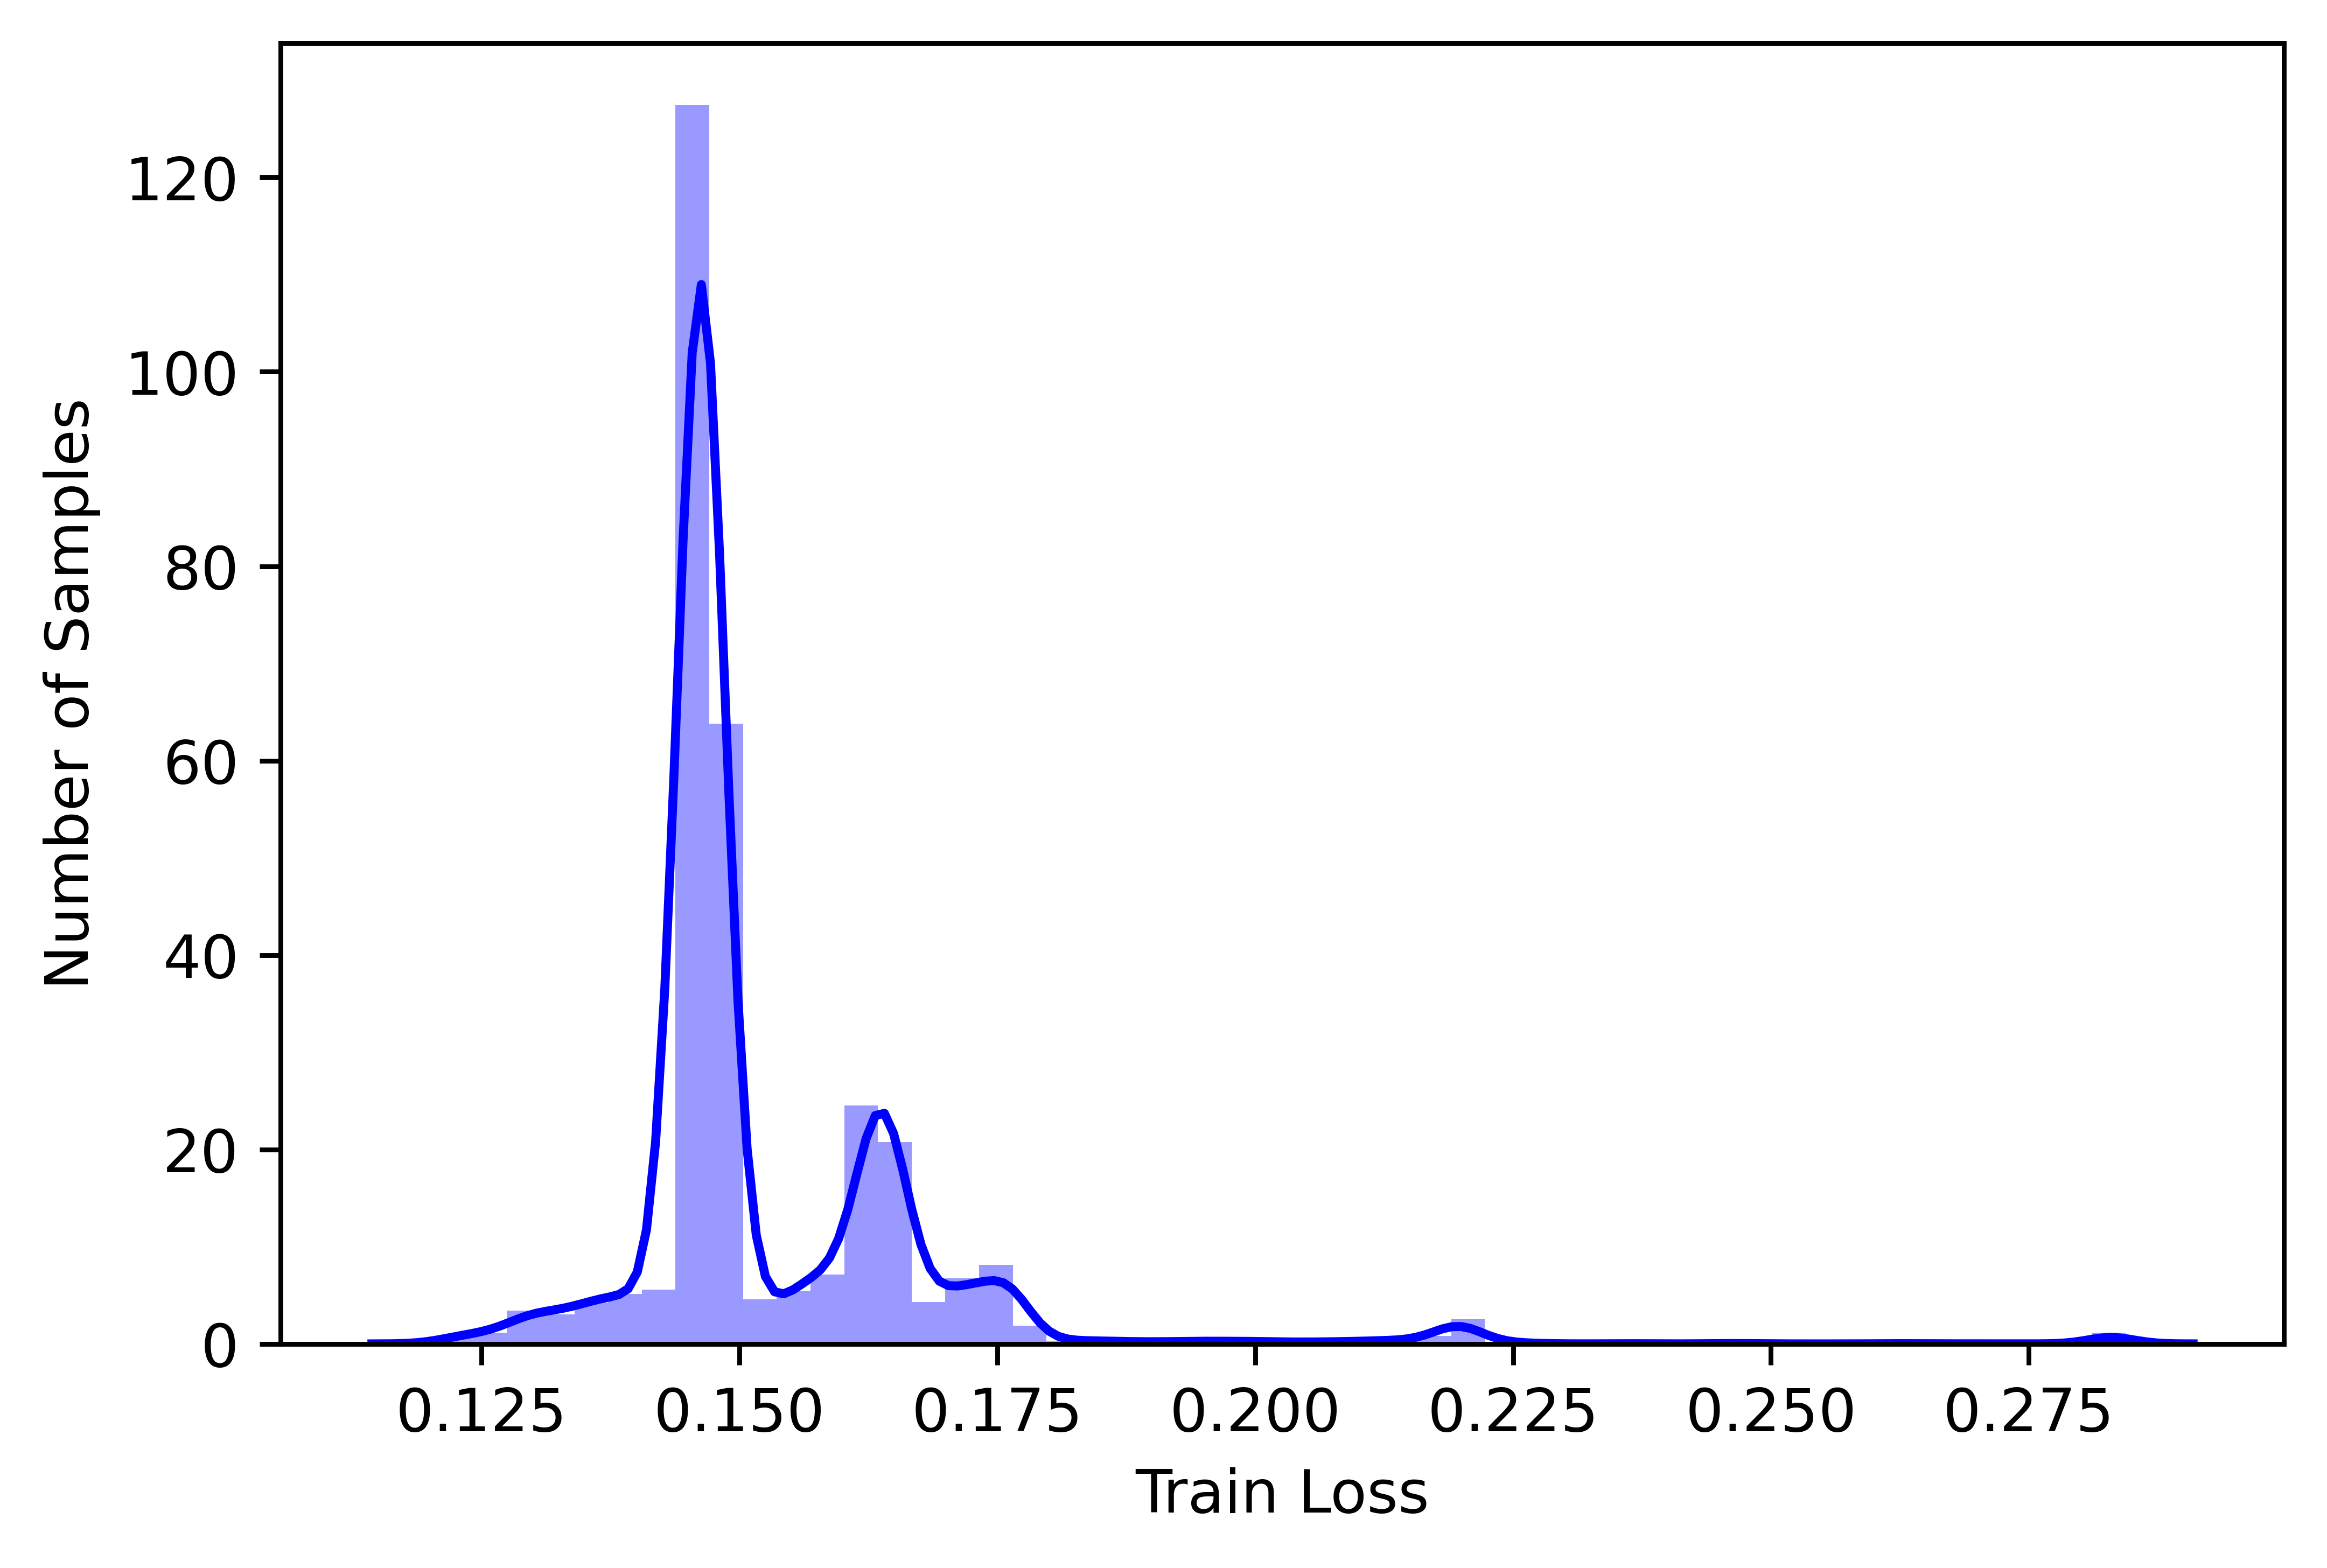

In [166]:
# Plot the histogram using seaborn
plt.subplots(dpi=800)

dist_sns = sns.distplot(train_loss[None,:], color="b")

plt.xlabel("Train Loss")
plt.ylabel("Number of Samples")
plt.savefig("sns_distri.png")


In [167]:
#threshold = np.mean(train_loss) + np.std(train_loss)
# Compute the median and MAD of the reconstruction error
b = 1.4826
median = np.median(train_loss)
mad = b * np.median(np.abs(train_loss - median))

# Set the threshold based on the median and MAD
k = 3
threshold = median + k * mad

print("Threshold: ", threshold) 

Threshold:  0.15327940618097782


140/140 [==============================] - 0s 700us/step


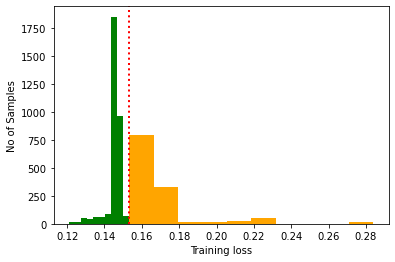

In [168]:
reconstructions = autoencoder.predict(test_data_norm)
train_loss = tf.keras.losses.binary_crossentropy(reconstructions, test_data_norm)

a=np.array(train_loss[None,:] )

anomaly = a[a >= threshold]
normal =  a[a < threshold]

plt.hist(normal, color='g')
plt.hist(anomaly, color='orange')
plt.xlabel("Training loss")
plt.ylabel("No of Samples")

plt.axvline(threshold, color='red', linestyle='dotted', linewidth=2)
plt.savefig("Anomaly Sample.png")
plt.show()

In [169]:
reconstructions = autoencoder.predict(test_data_norm)
test_loss = tf.keras.losses.binary_crossentropy(reconstructions, test_data_norm)

a=np.array(test_loss[None,:])

140/140 [==============================] - 0s 609us/step


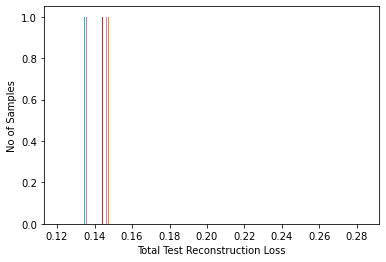

In [170]:
plt.hist(a, bins=50)
plt.xlabel("Total Test Reconstruction Loss")
plt.ylabel("No of Samples")
plt.show()
plt.close()

In [171]:
(a[a > threshold]).shape

(1249,)

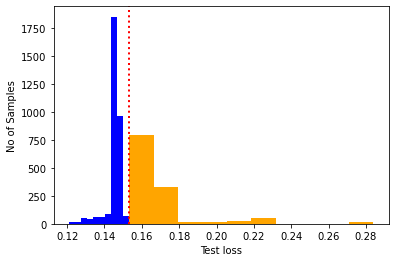

In [172]:
anomaly = a[a >= threshold]

normal =  a[a < threshold]

plt.hist(normal, color='b')
plt.hist(anomaly, color='orange')
plt.xlabel("Test loss")
plt.ylabel("No of Samples")

plt.axvline(threshold, color='red', linestyle='dotted', linewidth=2)
plt.savefig("Test Anomaly Sample.png")
plt.show()


In [173]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.binary_crossentropy(reconstructions, data)
    return reconstructions, loss, tf.math.less(loss, threshold) #Returns the truth value of (loss < threshold) element-wise.

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [174]:
model, rec_loss, pred_ = predict(autoencoder, test_data_norm, threshold)


In [175]:
tf.math.less_equal(5,2)

<tf.Tensor: shape=(), dtype=bool, numpy=False>

### Reconstruction score is the mean of reconstruction eror

In [176]:
reconstruction_score = np.mean(rec_loss)
print(reconstruction_score)

0.15235955


In [177]:
pred_

<tf.Tensor: shape=(4465,), dtype=bool, numpy=array([ True,  True,  True, ...,  True,  True, False])>

#### Number of anomalous data

In [178]:
normal_shape = tf.math.count_nonzero(pred_)
normal_shape

<tf.Tensor: shape=(), dtype=int64, numpy=3216>

In [179]:
#normal_shape=pred_.shape - anomaly_shape
norm = tf.math.equal(pred_, tf.constant(False))
anomaly_shape= tf.math.count_nonzero(norm)
anomaly_shape

<tf.Tensor: shape=(), dtype=int64, numpy=1249>

C:\Users\Kasutaja\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Kasutaja\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


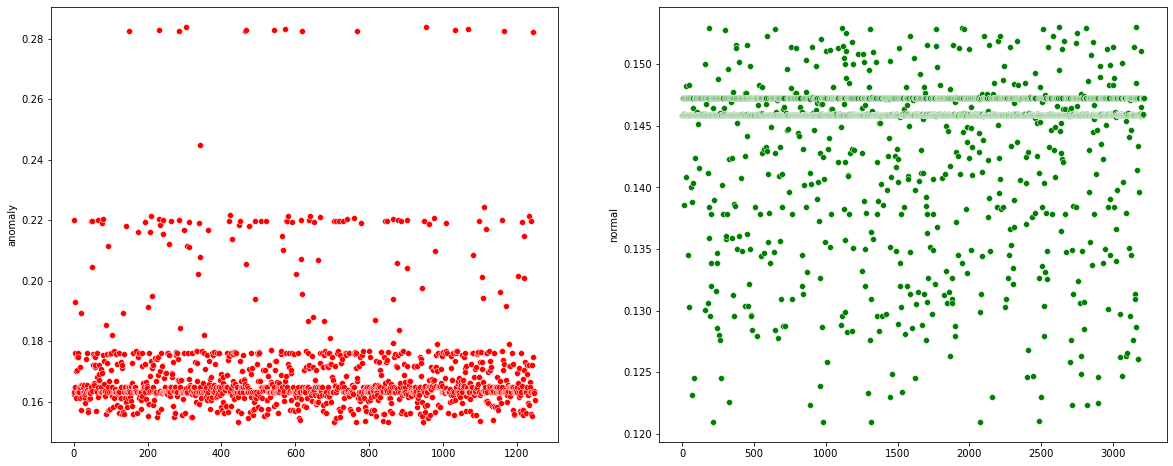

In [180]:
#sns.scatterplot(data=pred_, hue="time")
anomaly_pd = pd.DataFrame({'anomaly':anomaly})
#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
normal_pd = pd.DataFrame({'normal': normal})

#am_plt=plt.scatter(anomaly_pd.index, anomaly_pd['anom'], color='r')
#plt.show()

#nm_plt=plt.scatter(normal_pd.index, normal_pd['norm'], color='g')
#plt.show

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.scatterplot(anomaly_pd.index, anomaly_pd['anomaly'], y="Anomaly", x='Index', color='red', ax=ax1)
sns.scatterplot(normal_pd.index, normal_pd['normal'], x='Index', color='green', ax=ax2)
plt.savefig('scatterplot.png')
plt.show()

### Added label to the test data

In [182]:
#x_test_df = pd.DataFrame(np.array(pred_).tolist())

#test_data_["Label"] = np.array(pred_).tolist()

In [183]:
test_data

,Time,Identifier,Src_IP,Src_MAC,Dest_IP,Dest_MAC,Src_Port,Dest_Port,Proto,Seq_Num,Ack_Num,TCP_Flag,Window_Size,TCP_Checksum,Packet_Length,Payload
16727,1.518613e+09,27218,29,1,1,1,80.0,49550.0,1518612808.966243,2.120605e+09,4.015752e+09,0.0,1022.0,14781.0,1500.0,1.759091
15337,1.518613e+09,19081,0,0,27,0,49550.0,80.0,1518612808.876375,4.015752e+09,2.119166e+09,0.0,4809.0,64999.0,40.0,1.585054
9505,1.518613e+09,17299,0,0,27,0,49550.0,80.0,1518612807.834307,4.015751e+09,2.113260e+09,0.0,4860.0,64999.0,40.0,1.585054
10957,1.518613e+09,23156,29,1,1,1,80.0,49550.0,1518612807.941608,2.114679e+09,4.015751e+09,0.0,1023.0,5678.0,1500.0,1.759091
7417,1.518613e+09,20866,29,1,1,1,80.0,49550.0,1518612806.86374,2.111433e+09,4.015751e+09,0.0,1025.0,14067.0,1500.0,1.759091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6626,1.518613e+09,16105,0,0,27,0,49550.0,80.0,1518612806.838952,4.015751e+09,2.110522e+09,0.0,3695.0,65011.0,52.0,1.585054
3974,1.518612e+09,19159,20,1,1,1,443.0,49524.0,1518612312.827559,8.065722e+08,4.532528e+08,0.0,513.0,13685.0,1500.0,1.769231
15102,1.518613e+09,26072,29,1,1,1,80.0,49550.0,1518612808.859389,2.118932e+09,4.015752e+09,0.0,1022.0,2083.0,1500.0,1.759091
17807,1.518613e+09,19802,0,0,27,0,49550.0,80.0,1518612809.037204,4.015752e+09,2.121719e+09,0.0,3993.0,64999.0,40.0,1.585054


In [184]:
test_data.to_csv("Detected_Anomaly_Sparse_AE.csv")

In [185]:
test_data

,Time,Identifier,Src_IP,Src_MAC,Dest_IP,Dest_MAC,Src_Port,Dest_Port,Proto,Seq_Num,Ack_Num,TCP_Flag,Window_Size,TCP_Checksum,Packet_Length,Payload
16727,1.518613e+09,27218,29,1,1,1,80.0,49550.0,1518612808.966243,2.120605e+09,4.015752e+09,0.0,1022.0,14781.0,1500.0,1.759091
15337,1.518613e+09,19081,0,0,27,0,49550.0,80.0,1518612808.876375,4.015752e+09,2.119166e+09,0.0,4809.0,64999.0,40.0,1.585054
9505,1.518613e+09,17299,0,0,27,0,49550.0,80.0,1518612807.834307,4.015751e+09,2.113260e+09,0.0,4860.0,64999.0,40.0,1.585054
10957,1.518613e+09,23156,29,1,1,1,80.0,49550.0,1518612807.941608,2.114679e+09,4.015751e+09,0.0,1023.0,5678.0,1500.0,1.759091
7417,1.518613e+09,20866,29,1,1,1,80.0,49550.0,1518612806.86374,2.111433e+09,4.015751e+09,0.0,1025.0,14067.0,1500.0,1.759091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6626,1.518613e+09,16105,0,0,27,0,49550.0,80.0,1518612806.838952,4.015751e+09,2.110522e+09,0.0,3695.0,65011.0,52.0,1.585054
3974,1.518612e+09,19159,20,1,1,1,443.0,49524.0,1518612312.827559,8.065722e+08,4.532528e+08,0.0,513.0,13685.0,1500.0,1.769231
15102,1.518613e+09,26072,29,1,1,1,80.0,49550.0,1518612808.859389,2.118932e+09,4.015752e+09,0.0,1022.0,2083.0,1500.0,1.759091
17807,1.518613e+09,19802,0,0,27,0,49550.0,80.0,1518612809.037204,4.015752e+09,2.121719e+09,0.0,3993.0,64999.0,40.0,1.585054


## Packet to Images CNN Model

In [186]:
"""# Define a function to convert a row to bytes
def row_to_bytes(row):
    # Convert the row to a byte string
    #byte_row = ','.join([str(x) for x in row]).encode('utf-8')
    byte_lst=[]
    target_shape = (11, 11) #Desired shape
    
    for x in row:
        byte_row = str(x).encode('utf-8')
        # Convert the bytes to a NumPy array
        packet_data = np.frombuffer(byte_row, dtype=np.uint8)
        byte_lst.append(packet_data)
    
    #concatenate=np.concatenate(byte_lst)
    #np.array(concatenate.resize(target_shape))
    #plt.imshow(concatenate, cmap='gray')
    #plt.axis('off')
    #plt.savefig(f'ImageDataset/train/img_{index}.png')
    
    return byte_lst

def row_to_image(row):
    #image_list=[]
    #target_shape = (11, 11) #Desired shape
    
    #for conc in row:
    concatenate=np.concatenate(row)
    np.array(concatenate.resize(target_shape))
    image_list.append(concatenate)
    
    return image_list

def row_to_train_image(arr_data, index):
    print(index)
    concatenate = np.concatenate(arr_data)
    target_shape = (11, 11) #Desired shape

    np.array(concatenate.resize(target_shape))
        
    plt.imshow(concatenate)
    plt.axis('off')
    
    for i in index:
        plt.savefig(f'ImageDataset2/Training/train/img_{i}.png', bbox_inches = 'tight', pad_inches = 0)

    
def row_to_test_image(arr_data, index):
    print(index)
    concatenate = np.concatenate(arr_data)
    target_shape = (11, 11) #Desired shape

    np.array(concatenate.resize(target_shape))
        
    plt.imshow(concatenate)
    plt.axis('off')
    for i in index:
        plt.savefig(f'ImageDataset2/Testing/test/img_{i}.png', bbox_inches = 'tight', pad_inches = 0)
    #plt.close()"""

"# Define a function to convert a row to bytes\ndef row_to_bytes(row):\n    # Convert the row to a byte string\n    #byte_row = ','.join([str(x) for x in row]).encode('utf-8')\n    byte_lst=[]\n    target_shape = (11, 11) #Desired shape\n    \n    for x in row:\n        byte_row = str(x).encode('utf-8')\n        # Convert the bytes to a NumPy array\n        packet_data = np.frombuffer(byte_row, dtype=np.uint8)\n        byte_lst.append(packet_data)\n    \n    #concatenate=np.concatenate(byte_lst)\n    #np.array(concatenate.resize(target_shape))\n    #plt.imshow(concatenate, cmap='gray')\n    #plt.axis('off')\n    #plt.savefig(f'ImageDataset/train/img_{index}.png')\n    \n    return byte_lst\n\ndef row_to_image(row):\n    #image_list=[]\n    #target_shape = (11, 11) #Desired shape\n    \n    #for conc in row:\n    concatenate=np.concatenate(row)\n    np.array(concatenate.resize(target_shape))\n    image_list.append(concatenate)\n    \n    return image_list\n\ndef row_to_train_image(arr_d

In [187]:
"""byte_df = train_data.apply(row_to_bytes, axis=1)
index=byte_df.index.values

byte_df.apply(row_to_train_image, index=index)"""

'byte_df = train_data.apply(row_to_bytes, axis=1)\nindex=byte_df.index.values\n\nbyte_df.apply(row_to_train_image, index=index)'

In [188]:
"""byte_df = test_data.apply(row_to_bytes, axis=1)
index=byte_df.index.values
byte_df.apply(row_to_test_image, index=index)"""

'byte_df = test_data.apply(row_to_bytes, axis=1)\nindex=byte_df.index.values\nbyte_df.apply(row_to_test_image, index=index)'

In [189]:
#plt.close()

## Isolation Forest Model

#### Isolation Forest Training

In [190]:
iso_forest = IsolationForest(contamination=0.3,random_state=42)
iso_forest.fit(train_data_norm)
#iso_forest.n_features_in_

IsolationForest(contamination=0.3, random_state=42)

In [191]:
len(train_data_norm)

17857

In [192]:
iso_predict = iso_forest.predict(test_data_norm)

In [193]:
empty_df_iso = pd.DataFrame()

In [194]:
empty_df_iso['scores']=iso_forest.decision_function(test_data_norm)

In [195]:
empty_df_iso['iso_f_label'] = iso_predict
#outliers = empty_df.loc[empty_df['iso_f_label'] == -1]
#outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
empty_df_iso['iso_f_label'].value_counts()

 1    3145
-1    1320
Name: iso_f_label, dtype: int64

In [196]:
#acc = 100 * list(empty_df['iso_f_label'].value_counts(-1))/((empty_df['iso_f_label'] == -1))
empty_df_iso.head(5)
#a[a < threshold]
#print(f"Accuracy = {acc}")

,scores,iso_f_label
0,0.146545,1
1,0.135883,1
2,0.140049,1
3,0.141388,1
4,0.145726,1


### Local Outlier Factor (LOF) Model

In [197]:
lof = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, contamination=0.3, novelty=False)


In [198]:
#lof_fit = lof.fit(train_data_norm)
#n_errors = (y_pred != ground_truth).sum()
lof_pred=lof.fit_predict(test_data_norm)
lof_scores = lof.negative_outlier_factor_

In [199]:
empty_df_lof = pd.DataFrame()
empty_df_lof['lof_label'] = lof_pred
empty_df_lof['lof_score'] = lof_scores
#outliers = empty_df.loc[empty_df['iso_f_label'] == -1]
#outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(empty_df_lof['lof_label'].value_counts())

 1    3125
-1    1340
Name: lof_label, dtype: int64
